In [1]:
import nltk
from nltk.tokenize import word_tokenize
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') #Setting style sheets that we're using for plot
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from scipy.stats import chi2_contingency

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
calls = pd.read_csv('calls.csv')
customers = pd.read_csv('customers.csv')
reason = pd.read_csv('reason.csv')
sentiment = pd.read_csv('sentiment_statisticsc.csv')
test = pd.read_csv('test.csv')

In [3]:
reason.head()

,call_id,primary_call_reason
0,4667960400,Voluntary Cancel
1,1122072124,Booking
2,6834291559,IRROPS
3,2266439882,Upgrade
4,1211603231,Seating


In [4]:
reason['primary_call_reason'].value_counts()

IRROPS                     13057
Voluntary Change           10291
Seating                     6223
Mileage Plus                5487
Post-Flight                 3869
Communications              3779
Products and Services       2792
Upgrade                     2682
Baggage                     2616
Booking                     2589
Checkout                    1840
Check-In                    1490
Voluntary Cancel            1304
Digital Support              996
ETC                          930
Traveler Updates             772
Schedule Change              707
Other Topics                 568
Products & Services          476
Disability                   394
Check In                     385
Post Flight                  373
Voluntary  Cancel            278
IRROPS                       254
Other  Topics                234
Voluntary Change             208
Voluntary   Change           200
Voluntary  Change            149
Seating                      142
Digital   Support            136
Mileage  P

In [5]:
sentiment.head()


,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,963118,neutral,angry,-0.04,0.39
1,1122072124,519057,calm,neutral,0.02,0.35
2,6834291559,158319,neutral,polite,-0.13,0.32
3,2266439882,488324,neutral,frustrated,-0.20,0.20
4,1211603231,721730,neutral,polite,-0.05,0.35


In [6]:
sentiment_df = sentiment.groupby('agent_tone')['average_sentiment'].mean().reset_index()
sentiment_df

,agent_tone,average_sentiment
0,angry,-0.616478
1,calm,0.101289
2,frustrated,-0.329978
3,neutral,-0.080355
4,polite,0.673793


In [7]:
sentiment['agent_tone'].value_counts()

neutral       42758
calm          24675
frustrated     3684
angry           389
polite           87
Name: agent_tone, dtype: int64

In [8]:
sentiment['customer_tone'].value_counts()

neutral       14444
angry         14408
polite        14371
calm          14347
frustrated    14240
Name: customer_tone, dtype: int64

In [9]:
calls_shape = calls.shape
customers_shape = customers.shape
reason_shape = reason.shape
sentiment_shape = sentiment.shape

In [10]:
print(calls_shape)
print(customers_shape)
print(reason_shape)
print(sentiment_shape)

(71810, 7)
(71810, 3)
(66653, 2)
(71810, 6)


In [11]:
calls.tail()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript
71805,1563273072,8022667294,413148,8/31/2024 23:48,8/31/2024 23:57,9/1/2024 0:25,\n\nAgent: Thank you for calling United Airlin...
71806,8865997781,4474867021,980156,8/31/2024 23:55,8/31/2024 23:58,9/1/2024 0:06,\n\nAgent: Thank you for calling United Airlin...
71807,8019240181,9762042472,616988,8/31/2024 23:52,8/31/2024 23:58,9/1/2024 0:04,\n\nAgent: Thank you for calling United Airlin...
71808,8332067080,8095620266,161354,8/31/2024 23:53,8/31/2024 23:59,9/1/2024 0:03,\n\nAgent: Thank you for calling United Airlin...
71809,8210720833,8014388758,547592,8/31/2024 23:49,8/31/2024 23:59,9/1/2024 0:02,\n\nAgent: Thank you for calling United Airlin...


In [12]:
sentiment.tail()

,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
71805,1563273072,413148,calm,calm,0.05,0.34
71806,8865997781,980156,calm,frustrated,0.03,0.22
71807,8019240181,616988,calm,polite,0.05,0.42
71808,8332067080,161354,neutral,polite,-0.07,0.13
71809,8210720833,547592,neutral,calm,0.00,0.10


In [13]:
reason_df = reason

In [14]:
reason_df.head()

,call_id,primary_call_reason
0,4667960400,Voluntary Cancel
1,1122072124,Booking
2,6834291559,IRROPS
3,2266439882,Upgrade
4,1211603231,Seating


In [15]:
reason_df['primary_call_reason'] = (reason_df['primary_call_reason']
                .str.lower()                                  # Convert to lowercase
                .str.strip()                                  # Remove leading and trailing spaces
                .str.replace(r'\s+', ' ', regex=True))

In [16]:
reason_df['primary_call_reason'].value_counts()

irrops                   13311
voluntary change         10848
seating                   6365
mileage plus              5851
post-flight               3957
communications            3840
products and services     2856
baggage                   2832
upgrade                   2738
booking                   2637
checkout                  1888
voluntary cancel          1607
check-in                  1519
digital support           1225
etc                        952
traveler updates           937
other topics               818
schedule change            731
products & services        476
disability                 403
check in                   385
post flight                373
unaccompanied minor        104
Name: primary_call_reason, dtype: int64

In [17]:
from wordcloud import WordCloud

In [18]:
calls.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...


In [19]:
calls.shape

(71810, 7)

In [20]:
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])

In [21]:
calls['Handle_Time'] = calls['call_end_datetime'] - calls['agent_assigned_datetime']
calls['Waiting_Time'] = calls['agent_assigned_datetime'] - calls['call_start_datetime']


In [22]:
calls.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:31:00,0 days 00:07:00
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:12:00,0 days 00:03:00
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:19:00,0 days 00:08:00
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:07:00,0 days 00:05:00
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:09:00,0 days 00:10:00


In [23]:
# Define the maximum duration limit of 23:59:59
max_duration = pd.Timedelta(hours=23, minutes=59, seconds=59)

# Filter the DataFrame to find calls with duration longer than 23:59:59
long_calls = calls[calls['Handle_Time'] > max_duration]

# Display the long calls, if any
print(long_calls)

Empty DataFrame
Columns: [call_id, customer_id, agent_id, call_start_datetime, agent_assigned_datetime, call_end_datetime, call_transcript, Handle_Time, Waiting_Time]
Index: []


In [24]:
calls['Handle_Time'] = calls['Handle_Time'].apply(lambda x: str(x).replace('0 days ', '') if '0 days' in str(x) else str(x))
calls['Waiting_Time'] = calls['Waiting_Time'].apply(lambda x: str(x).replace('0 days ', '') if '0 days' in str(x) else str(x))

In [25]:
calls.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,00:31:00,00:07:00
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,00:12:00,00:03:00
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,00:19:00,00:08:00
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,00:07:00,00:05:00
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,00:09:00,00:10:00


# AHT (Average Handle Time) and AST(Average Speed to Answer)

In [26]:
calls['Handle_Time'] = pd.to_timedelta(calls['Handle_Time'])
tt_handle_time = calls['Handle_Time'].sum()

calls['Waiting_Time'] = pd.to_timedelta(calls['Waiting_Time'])
tt_waiting_time = calls['Waiting_Time'].sum()

In [27]:
time_delta_1 = pd.Timedelta(tt_handle_time)
time_delta_2 = pd.Timedelta(tt_waiting_time)

# Convert the timedelta to total minutes
total_handle_time = time_delta_1.total_seconds() / 60
total_waiting_time = time_delta_2.total_seconds() / 60

# Display the total minutes
print(f"Total Handle Time: {total_handle_time}")
print(f"Total Waiting Time: {total_waiting_time}")

Total Handle Time: 834251.0
Total Waiting Time: 523097.0


In [28]:
Total_calls = calls['call_id'].count()

AHT = round((total_handle_time/Total_calls), 1)
AST = round((total_waiting_time/Total_calls), 1)

print(f"AHT: {AHT}")
print(f"AST: {AST}")

AHT: 11.6
AST: 7.3


In [29]:
calls_sentiment = pd.merge(calls, sentiment, on='call_id', how='outer')
calls_sentiment = calls_sentiment.drop(columns=['agent_id_y'])
calls_sentiment.rename(columns={'agent_id_x': 'agent_id'}, inplace=True)
calls_sentiment.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:31:00,0 days 00:07:00,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:12:00,0 days 00:03:00,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:19:00,0 days 00:08:00,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:07:00,0 days 00:05:00,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:09:00,0 days 00:10:00,neutral,polite,-0.05,0.35


In [30]:
calls_sentiment['Handle_Time'] = pd.to_numeric(
    calls_sentiment['Handle_Time'])
calls_sentiment['Waiting_Time'] = pd.to_numeric(
    calls_sentiment['Waiting_Time'])

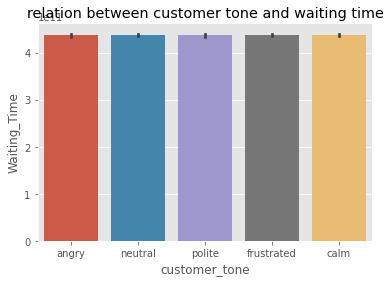

In [31]:
ax = sns.barplot(data=calls_sentiment, x='customer_tone', y='Waiting_Time')
ax.set_title('relation between customer tone and waiting time')
plt.show()

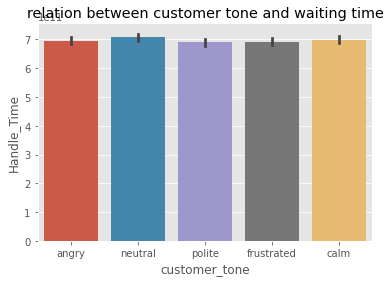

In [32]:
ax = sns.barplot(data=calls_sentiment, x='customer_tone', y='Handle_Time')
ax.set_title('relation between customer tone and waiting time')
plt.show()

In [33]:
correlation = calls_sentiment['silence_percent_average'].corr(calls_sentiment['average_sentiment'])

print("Pearson correlation between silence and average_sentiment:", correlation)

Pearson correlation between silence and average_sentiment: 0.03533890574144503


In [34]:
categorical_columns = ['agent_tone', 'customer_tone']
calls_sentiment_encoded = pd.get_dummies(calls_sentiment, columns=categorical_columns)

In [35]:
correlation_matrix = calls_sentiment[[
    'Handle_Time','Waiting_Time', 'agent_tone', 'customer_tone', 
    'average_sentiment', 'silence_percent_average']].corr()
correlation_matrix

,Handle_Time,Waiting_Time,average_sentiment,silence_percent_average
Handle_Time,1.000000,-0.027778,-0.076065,0.406883
Waiting_Time,-0.027778,1.000000,0.039881,-0.012068
average_sentiment,-0.076065,0.039881,1.000000,0.035339
silence_percent_average,0.406883,-0.012068,0.035339,1.000000


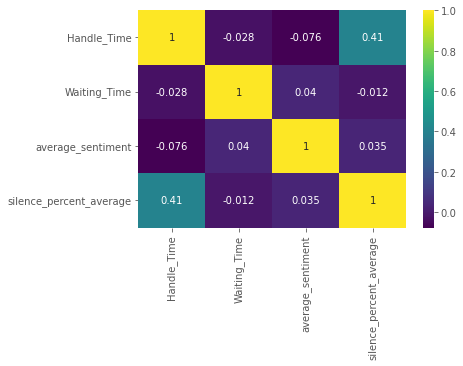

In [36]:
sns.heatmap(correlation_matrix, annot=True, cmap="viridis")
plt.show()

In [37]:
calls_sentiment['agent_tone'].value_counts().to_frame()

,agent_tone
neutral,42758
calm,24675
frustrated,3684
angry,389
polite,87


In [38]:
calls_sentiment['customer_tone'].value_counts().to_frame()

,customer_tone
neutral,14444
angry,14408
polite,14371
calm,14347
frustrated,14240


In [39]:
categorical_columns = ['agent_tone', 'customer_tone']
numeric_columns = ['average_sentiment', 'silence_percent_average']

# One-hot encode the categorical columns
df_encoded = pd.get_dummies(calls_sentiment, columns=categorical_columns)

# Calculate Pearson correlation (consider encoding other numeric columns if needed)
correlation_matrix = df_encoded.corr()


In [40]:
correlation_matrix

,call_id,customer_id,agent_id,Handle_Time,Waiting_Time,average_sentiment,silence_percent_average,agent_tone_angry,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_angry,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite
call_id,1.000000,-0.002907,-0.001021,-0.005040,-0.001266,-0.003442,-0.001415,-0.002078,-0.005403,0.001938,0.004834,-0.003292,0.003678,0.002179,-0.008829,0.005712,-0.002784
customer_id,-0.002907,1.000000,-0.001942,-0.001668,-0.000648,0.005481,0.001525,-0.003138,0.005827,0.002351,-0.005411,0.002681,0.002450,-0.008945,0.004701,0.000078,0.001724
agent_id,-0.001021,-0.001942,1.000000,0.001431,-0.000426,-0.003600,-0.001269,-0.010449,-0.000382,0.008301,-0.002659,0.005227,0.004836,-0.000460,0.003768,0.000093,-0.008228
Handle_Time,-0.005040,-0.001668,0.001431,1.000000,-0.027778,-0.076065,0.406883,-0.028847,-0.065923,-0.024020,0.083397,-0.021458,-0.000982,0.001649,-0.002768,0.006854,-0.004773
Waiting_Time,-0.001266,-0.000648,-0.000426,-0.027778,1.000000,0.039881,-0.012068,-0.005849,0.030931,-0.019496,-0.021063,0.005603,-0.002064,0.002529,-0.000869,0.002279,-0.001879
average_sentiment,-0.003442,0.005481,-0.003600,-0.076065,0.039881,1.000000,0.035339,-0.299593,0.679474,-0.480083,-0.396116,0.171542,0.003806,0.003538,-0.003363,-0.000666,-0.003326
silence_percent_average,-0.001415,0.001525,-0.001269,0.406883,-0.012068,0.035339,1.000000,-0.036679,0.022207,-0.041390,0.004812,-0.005253,0.002440,-0.001578,-0.005233,0.008802,-0.004469
agent_tone_angry,-0.002078,-0.003138,-0.010449,-0.028847,-0.005849,-0.299593,-0.036679,1.000000,-0.053397,-0.017162,-0.089533,-0.002570,-0.000497,-0.004611,0.004216,0.000831,0.000072
agent_tone_calm,-0.005403,0.005827,-0.000382,-0.065923,0.030931,0.679474,0.022207,-0.053397,1.000000,-0.168252,-0.877763,-0.025199,-0.002109,0.002431,-0.000226,0.001450,-0.001546
agent_tone_frustrated,0.001938,0.002351,0.008301,-0.024020,-0.019496,-0.480083,-0.041390,-0.017162,-0.168252,1.000000,-0.282114,-0.008099,-0.001129,-0.007425,0.004664,0.000156,0.003745


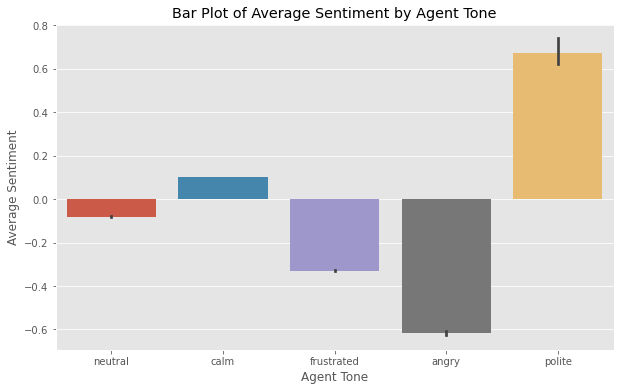

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x='agent_tone', y='average_sentiment', data=calls_sentiment)
plt.title('Bar Plot of Average Sentiment by Agent Tone')
plt.xlabel('Agent Tone')
plt.ylabel('Average Sentiment')
plt.show()

In [42]:
reason.head()

,call_id,primary_call_reason
0,4667960400,voluntary cancel
1,1122072124,booking
2,6834291559,irrops
3,2266439882,upgrade
4,1211603231,seating


In [43]:
reason['primary_call_reason'] = (reason['primary_call_reason']
                .str.lower()                                  # Convert to lowercase
                .str.strip()                                  # Remove leading and trailing spaces
                .str.replace(r'\s+', ' ', regex=True))

reason['primary_call_reason'].value_counts()

irrops                   13311
voluntary change         10848
seating                   6365
mileage plus              5851
post-flight               3957
communications            3840
products and services     2856
baggage                   2832
upgrade                   2738
booking                   2637
checkout                  1888
voluntary cancel          1607
check-in                  1519
digital support           1225
etc                        952
traveler updates           937
other topics               818
schedule change            731
products & services        476
disability                 403
check in                   385
post flight                373
unaccompanied minor        104
Name: primary_call_reason, dtype: int64

In [44]:
calls_reason = pd.merge(reason, calls_sentiment, on='call_id', how='outer')
calls_reason.head()

,call_id,primary_call_reason,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,voluntary cancel,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,1860000000000,420000000000,neutral,angry,-0.04,0.39
1,1122072124,booking,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,720000000000,180000000000,calm,neutral,0.02,0.35
2,6834291559,irrops,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,1140000000000,480000000000,neutral,polite,-0.13,0.32
3,2266439882,upgrade,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,420000000000,300000000000,neutral,frustrated,-0.20,0.20
4,1211603231,seating,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,540000000000,600000000000,neutral,polite,-0.05,0.35


In [45]:
df_test = calls_reason[['agent_tone','customer_tone','primary_call_reason',
                        'Handle_Time', 'Waiting_Time','average_sentiment',
                        'silence_percent_average']]

In [46]:
df_gr_reason = df_test.groupby(['agent_tone','customer_tone' ],
                              as_index = False).mean()


In [47]:
df_pivot = df_gr_reason.pivot(index='agent_tone', columns = 'customer_tone')
df_pivot

Handle_Time                                            \
customer_tone         angry          calm    frustrated       neutral   
agent_tone                                                              
angry          4.979221e+11  3.529412e+11  3.900000e+11  3.472500e+11   
calm           6.164323e+11  6.349144e+11  6.294969e+11  6.278627e+11   
frustrated     6.306557e+11  6.080116e+11  5.784474e+11  6.541779e+11   
neutral        7.506405e+11  7.500035e+11  7.453723e+11  7.646453e+11   
polite         3.400000e+11  1.376471e+11  2.025000e+11  2.329412e+11   

                             Waiting_Time                              \
customer_tone        polite         angry          calm    frustrated   
agent_tone                                                              
angry          3.815385e+11  4.433766e+11  4.314706e+11  4.346512e+11   
calm           6.237218e+11  4.436611e+11  4.416039e+11  4.428098e+11   
frustrated     6.145861e+11  4.237705e+11  4.222642e+11  4.256842e+11   
neutral        7.405923e+11  4.333256e+11  4.367496e+11  4.342062e+11   
polite         1.831579e+11  4.566667e+11  5.329412e+11  4.500000e+11   

                                          average_sentiment            \
customer_tone       neutral        polite             angry      calm   
agent_tone                                                              
angry          4.095000e+11  4.069231e+11         -0.594675 -0.642500   
calm           4.455388e+11  4.440146e+11          0.103685  0.100173   
frustrated     4.328571e+11  4.173982e+11         -0.327773 -0.327417   
neutral        4.339988e+11  4.339412e+11         -0.080034 -0.080865   
polite         4.376471e+11  4.326316e+11          0.675556  0.738235   

                                             silence_percent_average  \
customer_tone frustrated   neutral    polite                   angry   
agent_tone                                                             
angry          -0.620465 -0.588375 -0.639744                0.235195   
calm            0.101585  0.099653  0.101379                0.295169   
frustrated     -0.330105 -0.331307 -0.332996                0.256913   
neutral        -0.080468 -0.079891 -0.080524                0.284452   
polite          0.674375  0.617059  0.664737                0.333889   

                                                        
customer_tone      calm frustrated   neutral    polite  
agent_tone                                              
angry          0.179265   0.186512  0.172000  0.177436  
calm           0.291233   0.288885  0.292575  0.289150  
frustrated     0.253890   0.236803  0.257493  0.252168  
neutral        0.285226   0.286138  0.290766  0.284795  
polite         0.200588   0.178125  0.281176  0.277368

In [48]:
# Create a contingency table
contingency_table = pd.crosstab(calls_reason['agent_tone'], 
                                calls_reason['customer_tone'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

# Interpretation
if p < 0.05:
    print("There is a statistically significant association between primary_call_reason and agent_tone.")
else:
    print("There is no statistically significant association between primary_call_reason and agent_tone.")

Chi-square statistic: 8.549295605214267
p-value: 0.9308087633775913
Degrees of freedom: 16
Expected frequencies:
[[  78.06298102   77.70980403   77.15015434   78.2803207    77.7967399 ]
 [4951.68137946 4929.27870043 4893.77907058 4965.46764348 4934.79320604]
 [ 739.29054517  735.94580476  730.64567765  741.34884695  736.76912547]
 [8580.50627855 8541.68586314 8480.17043566 8604.39576495 8551.2416577 ]
 [  17.45881581   17.37982764   17.25466177   17.50742391   17.39927088]]
There is no statistically significant association between primary_call_reason and agent_tone.


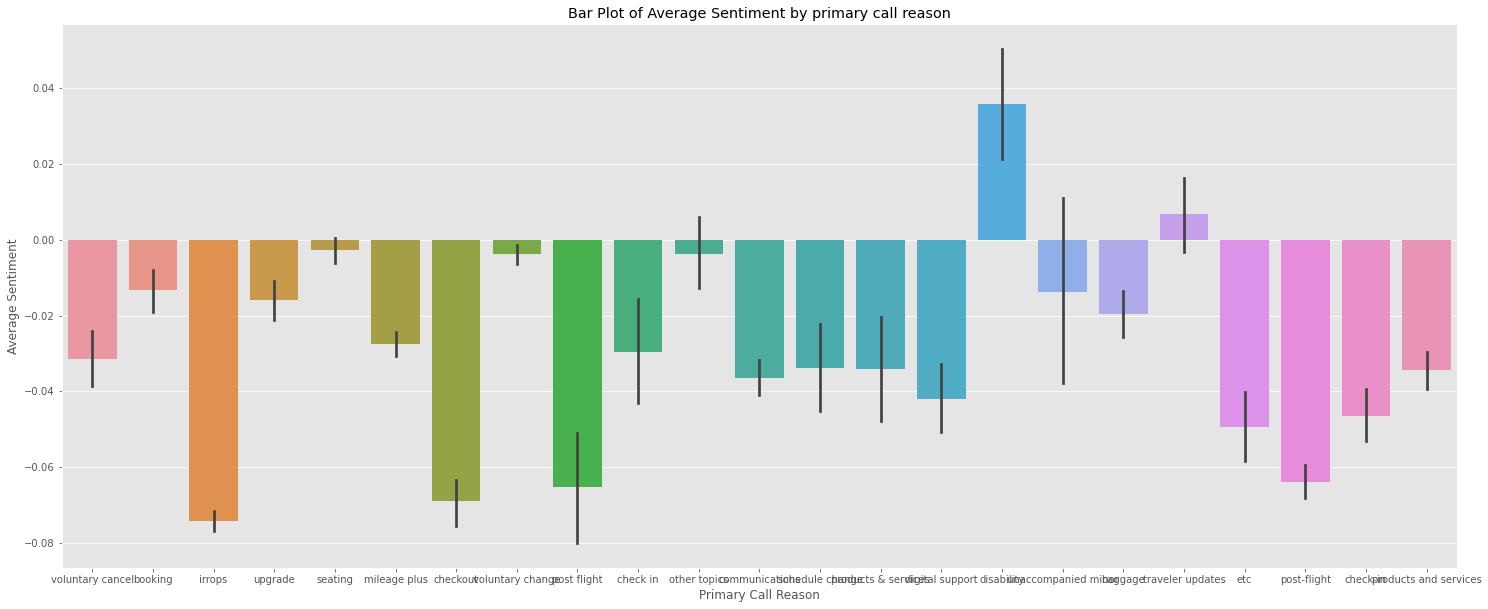

In [49]:
plt.figure(figsize=(25, 10))
sns.barplot(x='primary_call_reason', y='average_sentiment', data=calls_reason)
plt.title('Bar Plot of Average Sentiment by primary call reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('Average Sentiment')
plt.show()

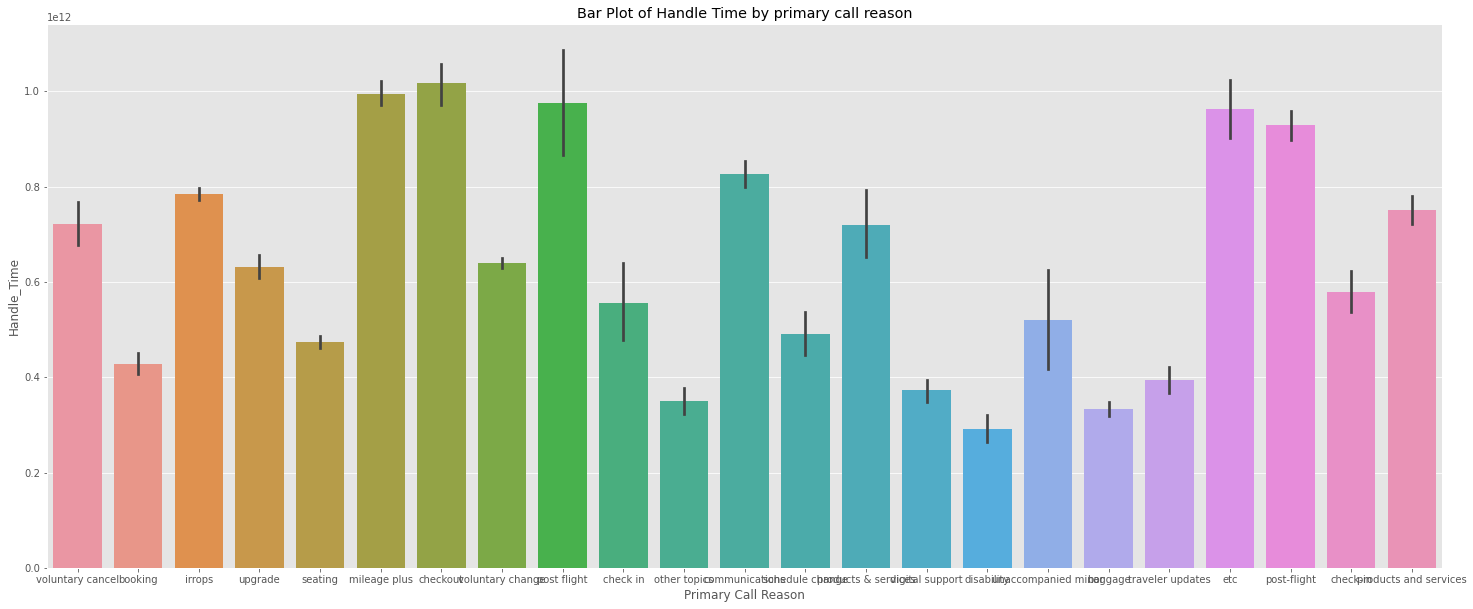

In [50]:
plt.figure(figsize=(25, 10))
sns.barplot(x='primary_call_reason', y='Handle_Time', data=calls_reason)
plt.title('Bar Plot of Handle Time by primary call reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('Handle_Time')
plt.show()

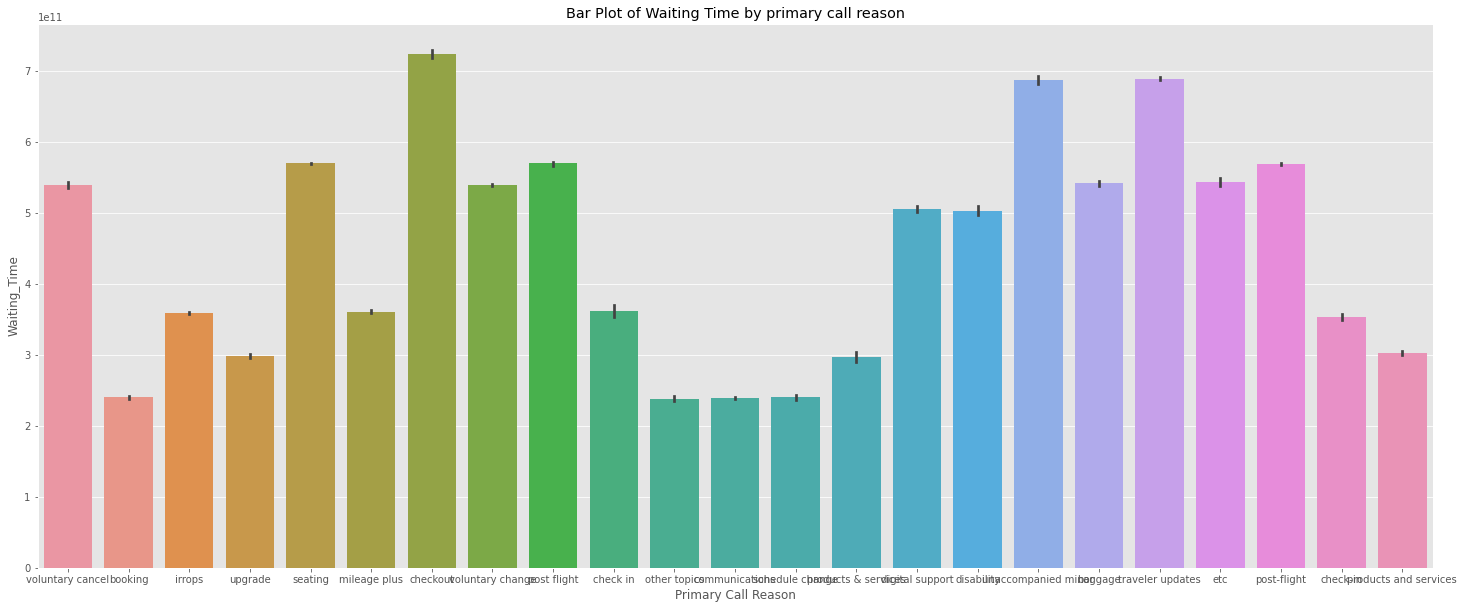

In [51]:
plt.figure(figsize=(25, 10))
sns.barplot(x='primary_call_reason', y='Waiting_Time', data=calls_reason)
plt.title('Bar Plot of Waiting Time by primary call reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('Waiting_Time')
plt.show()

In [52]:
calls_reason.head()

,call_id,primary_call_reason,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,voluntary cancel,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,1860000000000,420000000000,neutral,angry,-0.04,0.39
1,1122072124,booking,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,720000000000,180000000000,calm,neutral,0.02,0.35
2,6834291559,irrops,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,1140000000000,480000000000,neutral,polite,-0.13,0.32
3,2266439882,upgrade,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,420000000000,300000000000,neutral,frustrated,-0.20,0.20
4,1211603231,seating,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,540000000000,600000000000,neutral,polite,-0.05,0.35


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import string
import re

STOPWORDS = set(stopwords.words('english'))


In [54]:
def split_transcript(transcript):
    # Initialize lists to store the agent's and customer's lines
    agent_lines = []
    customer_lines = []
    
    # Split the transcript into lines
    lines = transcript.split('\n')
    
    # Loop through each line and categorize it
    for line in lines:
        if line.startswith("Agent:"):
            agent_lines.append(line.replace("Agent:", "").strip())
        elif line.startswith("Customer:"):
            customer_lines.append(line.replace("Customer:", "").strip())
    
    # Join the respective parts into a single string for agent and customer
    agent_text = ' '.join(agent_lines)
    customer_text = ' '.join(customer_lines)
    
    return agent_text, customer_text

# Apply the split function to each row in the dataset
calls_reason[['agent_conversation', 'customer_conversation']] = calls_reason['call_transcript'].apply(
    lambda transcript: pd.Series(split_transcript(transcript))
)

# Display the dataframe with the new columns
print(calls_reason[['call_transcript', 'agent_conversation', 'customer_conversation']].head())

                                     call_transcript  \
0  \n\nAgent: Thank you for calling United Airlin...   
1  \n\nAgent: Thank you for calling United Airlin...   
2  \n\nAgent: Thank you for calling United Airlin...   
3  \n\nAgent: Thank you for calling United Airlin...   
4  \n\nAgent: Thank you for calling United Airlin...   

                                  agent_conversation  \
0  Thank you for calling United Airlines customer...   
1  Thank you for calling United Airlines, my name...   
2  Thank you for calling United Airlines customer...   
3  Thank you for calling United Airlines customer...   
4  Thank you for calling United Airlines customer...   

                               customer_conversation  
0  Hi, yeah I'm calling because my flight from Ch...  
1  Hi Sam, yeah I'm calling because I need to cha...  
2  Hi Steve, uh, I'm calling because I need to ma...  
3  Hi, yeah I'm calling because I'm having some i...  
4  Hi Sarah, thanks for taking my call. I'm calli..

In [55]:
calls_reason.head()

,call_id,primary_call_reason,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average,agent_conversation,customer_conversation
0,4667960400,voluntary cancel,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,1860000000000,420000000000,neutral,angry,-0.04,0.39,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because my flight from Ch..."
1,1122072124,booking,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,720000000000,180000000000,calm,neutral,0.02,0.35,"Thank you for calling United Airlines, my name...","Hi Sam, yeah I'm calling because I need to cha..."
2,6834291559,irrops,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,1140000000000,480000000000,neutral,polite,-0.13,0.32,Thank you for calling United Airlines customer...,"Hi Steve, uh, I'm calling because I need to ma..."
3,2266439882,upgrade,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,420000000000,300000000000,neutral,frustrated,-0.20,0.20,Thank you for calling United Airlines customer...,"Hi, yeah I'm calling because I'm having some i..."
4,1211603231,seating,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,540000000000,600000000000,neutral,polite,-0.05,0.35,Thank you for calling United Airlines customer...,"Hi Sarah, thanks for taking my call. I'm calli..."


In [56]:
from transformers import pipeline

sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [57]:
def get_sentiment(text):
    if pd.isna(text) or len(text.strip()) == 0:
        return {'label': 'NEUTRAL', 'score': 0}  # Handling empty or NaN values
    result = sent_pipeline(text[:512])[0]  # Use [:512] to avoid truncation issues if text is too long
    return result

In [61]:
calls_reason_subset = calls_reason.head(1000)

calls_reason_subset.reset_index(drop=True, inplace=True)

# Save the new DataFrame to a CSV file
calls_reason_subset.to_csv('calls_reason_subset.csv', index=False)

In [ ]:
calls_reason_subset['agent_sentiment'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['label'])
calls_reason_subset['agent_sentiment_score'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['score'])

calls_reason_subset['customer_sentiment'] = calls_reason_subset['customer_conversation'].apply(lambda x: get_sentiment(x)['label'])
calls_reason_subset['customer_sentiment_score'] = calls_reason_subset['customer_conversation'].apply(lambda x: get_sentiment(x)['score'])

# Display the dataframe with the new sentiment columns
print(calls_reason_subset[['agent_conversation', 'agent_sentiment', 'agent_sentiment_score', 
                    'customer_conversation', 'customer_sentiment', 'customer_sentiment_score']].head())

In [65]:
calls_reason_subset['agent_conversation'].values[0]

"Thank you for calling United Airlines customer service, my name is Sarah how may I help you? I'm so sorry to hear about the delay, that's definitely frustrating. Umm, let me pull up your reservation and take a look at what happened. *typing sounds* Okay, it looks like there was severe weather in Chicago that caused multiple flight cancellations and delays across the board for all the airlines. Ahh shoot, yeah your original flight was scheduled to depart at 2pm but didn't actually take off until after 5pm. I understand your frustration sir, delays are never fun. Let me see what options I have available to help make this up to you. Hmm, it looks like I can get you booked on a flight leaving at 3pm tomorrow that will have you landing in New York by 5pm. I'll waive the change fee and provide you with a travel voucher for $200 to help cover expenses from the missed meetings today. Does that work for your schedule? You're right, we want to do better for our customers. I apologize again for 

In [67]:
calls_reason_subset['agent_sentiment'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['label'])
calls_reason_subset['agent_sentiment_score'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['score'])

calls_reason_subset['customer_sentiment'] = calls_reason_subset['customer_conversation'].apply(lambda x: get_sentiment(x)['label'])
calls_reason_subset['customer_sentiment_score'] = calls_reason_subset['customer_conversation'].apply(lambda x: get_sentiment(x)['score'])

# Display the dataframe with the new sentiment columns
print(calls_reason_subset[['agent_conversation', 'agent_sentiment', 'agent_sentiment_score', 
                    'customer_conversation', 'customer_sentiment', 'customer_sentiment_score']].head())

C:\Users\Anjum\AppData\Local\Temp\ipykernel_29764\2352362358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_reason_subset['agent_sentiment'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['label'])
C:\Users\Anjum\AppData\Local\Temp\ipykernel_29764\2352362358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_reason_subset['agent_sentiment_score'] = calls_reason_subset['agent_conversation'].apply(lambda x: get_sentiment(x)['score'])
C:\Users\Anjum\AppData\Local

                                  agent_conversation agent_sentiment  \
0  Thank you for calling United Airlines customer...        NEGATIVE   
1  Thank you for calling United Airlines, my name...        NEGATIVE   
2  Thank you for calling United Airlines customer...        NEGATIVE   
3  Thank you for calling United Airlines customer...        NEGATIVE   
4  Thank you for calling United Airlines customer...        NEGATIVE   

   agent_sentiment_score                              customer_conversation  \
0               0.998494  Hi, yeah I'm calling because my flight from Ch...   
1               0.988792  Hi Sam, yeah I'm calling because I need to cha...   
2               0.992585  Hi Steve, uh, I'm calling because I need to ma...   
3               0.932886  Hi, yeah I'm calling because I'm having some i...   
4               0.996007  Hi Sarah, thanks for taking my call. I'm calli...   

  customer_sentiment  customer_sentiment_score  
0           NEGATIVE                  0.999

C:\Users\Anjum\AppData\Local\Temp\ipykernel_29764\2352362358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_reason_subset['customer_sentiment_score'] = calls_reason_subset['customer_conversation'].apply(lambda x: get_sentiment(x)['score'])


In [59]:
print('Hello')

Hello


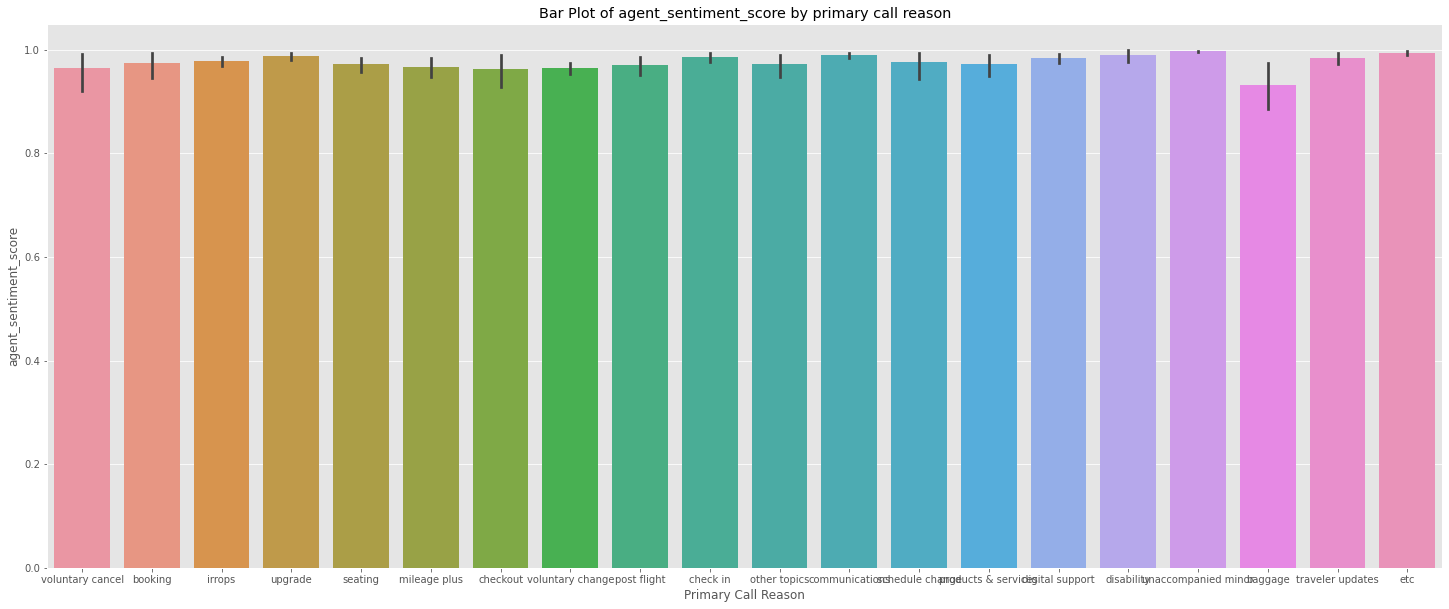

In [69]:
plt.figure(figsize=(25, 10))
sns.barplot(x='primary_call_reason', y='agent_sentiment_score', data=calls_reason_subset)
plt.title('Bar Plot of agent_sentiment_score by primary call reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('agent_sentiment_score')
plt.show()

In [70]:

# Step 1: Group by primary_call_reason and calculate the average Handle_Time
# Assuming Handle_Time is in minutes for the calculations
average_handle_times = calls_reason.groupby('primary_call_reason')['Handle_Time'].mean().reset_index()

# Step 2: Count the frequency of each primary_call_reason
frequency_counts = calls_reason['primary_call_reason'].value_counts()

# Step 3: Identify the most and least frequent call reasons
most_frequent_reason = frequency_counts.idxmax()
least_frequent_reason = frequency_counts.idxmin()

# Step 4: Get the average Handle_Time for the most and least frequent reasons
most_frequent_avg_time = average_handle_times.loc[average_handle_times['primary_call_reason'] == most_frequent_reason, 'Handle_Time'].values[0]
least_frequent_avg_time = average_handle_times.loc[average_handle_times['primary_call_reason'] == least_frequent_reason, 'Handle_Time'].values[0]

# Step 5: Calculate the percentage difference
percentage_difference = ((most_frequent_avg_time - least_frequent_avg_time) / least_frequent_avg_time) * 100

# Step 6: Print the results
print(f"Most Frequent Call Reason: {most_frequent_reason}, Average Handle Time: {most_frequent_avg_time:.2f} seconds")
print(f"Least Frequent Call Reason: {least_frequent_reason}, Average Handle Time: {least_frequent_avg_time:.2f} seconds")
print(f"Percentage Difference in Average Handle Time: {percentage_difference:.2f}%")


Most Frequent Call Reason: irrops, Average Handle Time: 785116069416.27 seconds
Least Frequent Call Reason: unaccompanied minor, Average Handle Time: 519230769230.77 seconds
Percentage Difference in Average Handle Time: 51.21%
